**Okay so prima facie, lets import some of the libraries we will be needing for this project.**  
(even if we are missing out on some library, we can always import it later on in the project.)

In [1]:
import sys
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

**Okay so now we will be able to load and manupulate our data.**  
**So let's get started with loading our data.**  

**Data source : https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64** 

**So our datasets contain model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada from the year of 1995 to 2020.**  

**A <u>note</u> from the data provider** : "To help you compare vehicles from different model years, the fuel consumption ratings for 1995 to 2014 vehicles have been adjusted to reflect the improved testing that is more representative of everyday driving. Note that these are approximate values that were generated from the original ratings, not from vehicle testing."

# Loading the data.

In [2]:
"""okay so the datasets when downloadong from the source was availaible in the chunks of - 
                1995 to 1999, 2000 to 2014, 2015, 2016, 2017, 2018, 2019 and 2020.
so we are converting each of those CSV files into a pandas dataframe so that we can ease of manuulation, and then we are going to 
concatenate all of them in order to get our full dataset.
The individual datasets have been named according to the corresponding years they relate to.
"""

df_95_99 = pd.read_csv("Original_1995-1999_Fuel_Consumption_Ratings_(2-cycle).csv")
print(df_95_99.shape)
df_00_14 = pd.read_csv("Original MY2000-2014 Fuel Consumption Ratings (2-cycle).csv")
print(df_00_14.shape)
df_15 = pd.read_csv("MY2015 Fuel Consumption Ratings (5-cycle).csv")
print(df_15.shape)
df_16 = pd.read_csv("MY2016 Fuel Consumption Ratings.csv")
print(df_16.shape)
df_17 = pd.read_csv("MY2017 Fuel Consumption Ratings.csv")
print(df_17.shape)
df_18 = pd.read_csv("MY2018 Fuel Consumption Ratings.csv")
print(df_18.shape)
df_19 = pd.read_csv("MY2019 Fuel Consumption Ratings.csv")
print(df_19.shape)
df_20 = pd.read_csv("MY2020 Fuel Consumption Ratings.csv")
print(df_20.shape)

(3520, 13)
(14281, 13)
(1133, 13)
(1109, 14)
(1057, 15)
(1084, 15)
(1047, 15)
(869, 15)


**okay so there are some extra columns in our data from 2016 till 2020**
**let's try to figure out what those are exactly.**
**So lets check the column names**

In [3]:
print(df_95_99.columns, df_00_14.columns, df_15.columns, df_16.columns, df_17.columns, df_18.columns, df_19.columns, df_20.columns)

Index(['MODEL', 'MAKE', 'MODEL.1', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'CO2 EMISSIONS '],
      dtype='object') Index(['MODEL', 'MAKE', 'MODEL.1', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'CO2 EMISSIONS '],
      dtype='object') Index(['MODEL', 'MAKE', 'MODEL.1', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION*', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'CO2 EMISSIONS '],
      dtype='object') Index(['MODEL', 'MAKE', 'MODEL.1', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'CO2 EMISSIONS ', 'CO2'],
      dtype='object') Index(['MODEL', 'MAKE', 'MODEL.1', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
       'TRANSMISSION

<b>So from 2016 the extra column that got added to the dataset is : <u>CO2</u> which according to the documentation in the<b/>
<b>data scource means: the tailpipe emissions of carbon dioxide rated on a scale from 1 (worst) to 10 (best), this si basically the categorical versin of the co2 emissions feature, whichmakes i redundant, so we are dropping this feature.<b/>
    
<b>And from 2017 the extra column that got added to the dataset is: <u>Smog</u> which according to the documentation in the<b/>
<b>data source means: the tailpipe emissions of smog-forming pollutants rated on a scale from 1 (worst) to 10 (best).<b/>
    

**so now the question is : do we keep the two extra <u>'Smog'</u> columns in out data or do we discard them?**  

**So our first option is if we keep the extra data; then what we we get is a lot of "NaN" values in these columns for the years before 2016. We can deal with them by the various techniques used to deal with NaN values; but the fundamental issue in that is if we are replacing the NaN values with some data by some technique then it is very much possible that it will have a significant skewed impact on our prediction, which is not desireable.**  

**And clearly so we are left with the second option; that is we will be dropping those columns from the datasets from 2016 to 2020, in order to get low variance in our prediction.**

In [4]:
df_16.drop("CO2", axis = 1, inplace = True) #because the "Smog" column is not present for the 2016 dataset.
df_17.drop(["CO2", "SMOG"], axis = 1, inplace = True)
df_18.drop(["CO2", "SMOG"], axis = 1, inplace = True)
df_19.drop(["CO2", "Smog"], axis = 1, inplace = True)
df_20.drop(["CO2", "Smog"], axis = 1, inplace = True)
print(df_16.shape, df_17.shape, df_18.shape, df_19.shape, df_20.shape)

(1109, 13) (1057, 13) (1084, 13) (1047, 13) (869, 13)


**okay so now that we have our columns uniform across the datasets of the various years, we can move forward to the next step.**  
**So we can also see from above that, the column names are uniform but they are different, i.e some of them are in upper case and some of them are lower case, this will create an issue during concatenating these datasets that, the program will understand two coulmns with same name but with differnt case of the words as two different coulmns, so lets solve this now.**

In [5]:
# let's make a list of the desired column names and then assign it to all the datasets.
col_names = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissioins"]
type(col_names)

list

**You can notice that the last few columns in our list of column names are: "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb".**  **These columns were previously: 'FUEL CONSUMPTION', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11' (yes there were 4 of them and we are intending to keep three of them).**

**So let's see what they meant: City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg).**
**So we decide to drop the 'Unnamed 11' collumn because it is 'redundant' as it represents the same thing as 'Unnamed 10' but in a different unit of measurement.**
**And as of the other three columns, we have intend to change them to the following: "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb".**

In [6]:
df_95_99.drop('Unnamed: 11',axis = 1, inplace = True)
df_00_14.drop('Unnamed: 11', axis = 1, inplace = True)
df_15.drop('Unnamed: 11', axis = 1, inplace = True)
df_16.drop('Unnamed: 11', axis = 1, inplace = True)
df_17.drop(['Unnamed: 11'], axis = 1, inplace = True)
df_18.drop(['Unnamed: 11'], axis = 1, inplace = True)
df_19.drop(['Unnamed: 11'], axis = 1, inplace = True)
df_20.drop(['Unnamed: 11'], axis = 1, inplace = True)

In [7]:
print(df_95_99.shape, df_00_14.shape, df_15.shape, df_16.shape, df_17.shape, df_18.shape, df_19.shape, df_20.shape)

(3520, 12) (14281, 12) (1133, 12) (1109, 12) (1057, 12) (1084, 12) (1047, 12) (869, 12)


**okay so now lets rename the colmn names and move forward with the concatenation.**

In [8]:
df_95_99.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_00_14.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_15.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_16.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_17.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_18.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_19.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
df_20.columns = ["Model", "Make", "Model.1", "Vehicle_class", "Engine_size", "Cylinders", "Transmission", "Fuel", "Fuel_con_city", "Fuel_con_hwy", "Fuel_con_comb" , "Co2_emissions"]
print(df_95_99.shape, df_00_14.shape, df_15.shape, df_16.shape, df_17.shape, df_18.shape, df_19.shape, df_20.shape)
print(df_95_99.columns, df_00_14.columns, df_15.columns, df_16.columns, df_17.columns, df_18.columns, df_19.columns, df_20.columns)

(3520, 12) (14281, 12) (1133, 12) (1109, 12) (1057, 12) (1084, 12) (1047, 12) (869, 12)
Index(['Model', 'Make', 'Model.1', 'Vehicle_class', 'Engine_size', 'Cylinders',
       'Transmission', 'Fuel', 'Fuel_con_city', 'Fuel_con_hwy',
       'Fuel_con_comb', 'Co2_emissions'],
      dtype='object') Index(['Model', 'Make', 'Model.1', 'Vehicle_class', 'Engine_size', 'Cylinders',
       'Transmission', 'Fuel', 'Fuel_con_city', 'Fuel_con_hwy',
       'Fuel_con_comb', 'Co2_emissions'],
      dtype='object') Index(['Model', 'Make', 'Model.1', 'Vehicle_class', 'Engine_size', 'Cylinders',
       'Transmission', 'Fuel', 'Fuel_con_city', 'Fuel_con_hwy',
       'Fuel_con_comb', 'Co2_emissions'],
      dtype='object') Index(['Model', 'Make', 'Model.1', 'Vehicle_class', 'Engine_size', 'Cylinders',
       'Transmission', 'Fuel', 'Fuel_con_city', 'Fuel_con_hwy',
       'Fuel_con_comb', 'Co2_emissions'],
      dtype='object') Index(['Model', 'Make', 'Model.1', 'Vehicle_class', 'Engine_size', 'Cylinders',


**Okay so lets concat our datasets, in order to get our final big dataset.**

In [9]:
all_datasets = [df_95_99, df_00_14, df_15, df_16, df_17, df_18, df_19, df_20]

data = pd.concat(all_datasets)

In [10]:
data.shape

(24100, 12)

**okay so we have 24100 rows and 12 columns in our final dataset.** 

In [11]:
data.head()

,Model,Make,Model.1,Vehicle_class,Engine_size,Cylinders,Transmission,Fuel,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
0,YEAR,NaN,# = high output engine,NaN,(L),NaN,NaN,TYPE,CITY (L/100 km),HWY (L/100 km),COMB (L/100 km),(g/km)
1,1995,ACURA,INTEGRA,SUBCOMPACT,1.8,4.0,A4,X,10.2,7,8.8,202
2,1995,ACURA,INTEGRA,SUBCOMPACT,1.8,4.0,M5,X,9.6,7,8.4,193
3,1995,ACURA,INTEGRA GS-R,SUBCOMPACT,1.8,4.0,M5,Z,9.4,7,8.3,191
4,1995,ACURA,LEGEND,COMPACT,3.2,6.0,A4,Z,12.6,8.9,10.9,251


In [12]:
data.tail()

,Model,Make,Model.1,Vehicle_class,Engine_size,Cylinders,Transmission,Fuel,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
864,2020,Volvo,XC40 T5 AWD,SUV: Small,2,4.0,AS8,Z,10.7,7.7,9.4,219
865,2020,Volvo,XC60 T5 AWD,SUV: Small,2,4.0,AS8,Z,11.2,8.3,9.9,232
866,2020,Volvo,XC60 T6 AWD,SUV: Small,2,4.0,AS8,Z,11.7,8.6,10.3,240
867,2020,Volvo,XC90 T5 AWD,SUV: Standard,2,4.0,AS8,Z,11.2,8.3,9.9,232
868,2020,Volvo,XC90 T6 AWD,SUV: Standard,2,4.0,AS8,Z,12.2,8.7,10.7,248


**let's see the column names that we have in our dataset.**

In [13]:
data.columns

Index(['Model', 'Make', 'Model.1', 'Vehicle_class', 'Engine_size', 'Cylinders',
       'Transmission', 'Fuel', 'Fuel_con_city', 'Fuel_con_hwy',
       'Fuel_con_comb', 'Co2_emissions'],
      dtype='object')

**Now lets reset the index of our dataframe, because of the fact that the different datasets that were merged have an index of their own, but that is not a desired outcome.**

In [14]:
data.set_index(np.arange(0,len(data),1), inplace = True)

In [15]:
data.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            24090, 24091, 24092, 24093, 24094, 24095, 24096, 24097, 24098,
            24099],
           dtype='int64', length=24100)

**Let's check for missing values in our dataset, as we can clearly see from above that the first row in our dataset is an extra row, which is the feature explanation part present in the CSV source file of the data.**

In [16]:
data.isnull().sum()

Model            0
Make             8
Model.1          6
Vehicle_class    8
Engine_size      0
Cylinders        8
Transmission     8
Fuel             0
Fuel_con_city    0
Fuel_con_hwy     0
Fuel_con_comb    0
Co2_emissions    0
dtype: int64

**okay so lets see the rows where there are missing values in our dataset.**

In [17]:
for col in data.columns:
    print("This is for {}".format(col))
    print(data[data[col].isnull()])

This is for Model
Empty DataFrame
Columns: [Model, Make, Model.1, Vehicle_class, Engine_size, Cylinders, Transmission, Fuel, Fuel_con_city, Fuel_con_hwy, Fuel_con_comb, Co2_emissions]
Index: []
This is for Make
      Model Make                 Model.1 Vehicle_class Engine_size  Cylinders  \
0      YEAR  NaN  # = high output engine           NaN         (L)        NaN   
3520   YEAR  NaN  # = high output engine           NaN         (L)        NaN   
17801  YEAR  NaN                     NaN           NaN         (L)        NaN   
18934  YEAR  NaN                     NaN           NaN         (L)        NaN   
20043  YEAR  NaN                     NaN           NaN         (L)        NaN   
21100  YEAR  NaN                     NaN           NaN         (L)        NaN   
22184  Year  NaN                     NaN           NaN         (L)        NaN   
23231  Year  NaN                     NaN           NaN         (L)        NaN   

      Transmission  Fuel    Fuel_con_city    Fuel_con_hwy  

**We can see that the index of the rows which has missing values in them re the same for all the features.**  
**The reason behind this is these rows are similar to the first row in our dataset, which are basically the feature explanation part present in the CSV source file.**  
(**So the logical next step is to discard all these rows, as we do not need them in our analysis**

In [18]:
data.dropna(axis = 0, how = 'any', inplace = True)
data.shape

(24092, 12)

**As we dont need the first three identity columns in our analysis, lets merge them into a single column.**

In [19]:
# merging the desired the ID featuring columns into one column as 'Year_make_model'
data['Year_make_model'] = data[['Model', 'Make', 'Model.1']].agg('-'.join, axis=1)
# dropping the original individual columns
data = data.drop(['Model', 'Make', 'Model.1'], 1)
# now lets rearrange the columns to get the merged column up in the front, by making a list of the column names in a desired arrangement
cols = ['Year_make_model', 'Vehicle_class', 'Engine_size', 'Cylinders', 'Transmission', 'Fuel', 'Fuel_con_city', 'Fuel_con_hwy', 'Fuel_con_comb', 'Co2_emissions']
data = data[cols]
data.head()

,Year_make_model,Vehicle_class,Engine_size,Cylinders,Transmission,Fuel,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
1,1995-ACURA-INTEGRA,SUBCOMPACT,1.8,4.0,A4,X,10.2,7,8.8,202
2,1995-ACURA-INTEGRA,SUBCOMPACT,1.8,4.0,M5,X,9.6,7,8.4,193
3,1995-ACURA-INTEGRA GS-R,SUBCOMPACT,1.8,4.0,M5,Z,9.4,7,8.3,191
4,1995-ACURA-LEGEND,COMPACT,3.2,6.0,A4,Z,12.6,8.9,10.9,251
5,1995-ACURA-LEGEND COUPE,COMPACT,3.2,6.0,A4,Z,13,9.3,11.3,260


In [20]:
data.tail()

,Year_make_model,Vehicle_class,Engine_size,Cylinders,Transmission,Fuel,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
24095,2020-Volvo-XC40 T5 AWD,SUV: Small,2,4.0,AS8,Z,10.7,7.7,9.4,219
24096,2020-Volvo-XC60 T5 AWD,SUV: Small,2,4.0,AS8,Z,11.2,8.3,9.9,232
24097,2020-Volvo-XC60 T6 AWD,SUV: Small,2,4.0,AS8,Z,11.7,8.6,10.3,240
24098,2020-Volvo-XC90 T5 AWD,SUV: Standard,2,4.0,AS8,Z,11.2,8.3,9.9,232
24099,2020-Volvo-XC90 T6 AWD,SUV: Standard,2,4.0,AS8,Z,12.2,8.7,10.7,248


In [21]:
# resetting the index, because we droped some rows
data.reset_index(drop=True, inplace=True)

**Checking the data types of our features in our dataset.**

In [22]:
data.dtypes

Year_make_model     object
Vehicle_class       object
Engine_size         object
Cylinders          float64
Transmission        object
Fuel                object
Fuel_con_city       object
Fuel_con_hwy        object
Fuel_con_comb       object
Co2_emissions       object
dtype: object

**As we can see above, some columns are not of the correct data type. Numerical variables should have type 'float' or 'int', and variables with strings such as categories should have type 'object'.**  
**Okay so lets change the dtypes of some of the columns.**

In [23]:
data.Engine_size = data.Engine_size.astype(str).astype(float)
data.Cylinders = data.Cylinders.astype(int)
data.Fuel_con_city = data.Fuel_con_city.astype(float)
data.Fuel_con_hwy = data.Fuel_con_hwy.astype(float)
data.Fuel_con_comb = data.Fuel_con_comb.astype(float)
data.Co2_emissions = data.Co2_emissions.astype(int)

data.dtypes

Year_make_model     object
Vehicle_class       object
Engine_size        float64
Cylinders            int32
Transmission        object
Fuel                object
Fuel_con_city      float64
Fuel_con_hwy       float64
Fuel_con_comb      float64
Co2_emissions        int32
dtype: object

# Variable Selection. 
**okay so lets understand the features of our dataset, and try to figure out two things:**  
* the TARGET VARIABLE (i.e Output)
* the PREDICTOR VARIABLE(S) (i.e Input)  

### Stating the problem statement.
**Okay so what we are trying to do is trying to predict the Co2 emissions by a car based on their:**  
* Number of cylinders in the engine
* Transmission type of the car
* Engine size of the car
* Class of vehicle it belongs to 
* Fuel it uses
* Fuel consumption by the car in:
    * city
    * highway
    * a combination of both    
**in Canada based on the data from 1995 to 2020.**  

**We wont be needing the variables called:**  
* Model: the year the car was made
* Make: Maker of the car
* Moel.1: model of a given car by a given maker in a given year  

**So our variables are:**  
* <u>TARGET VARIABLE</u> : Co2_emmisions
* <u>PREDICTOR VARIABLEs</u> : 
    * Vehicle_class
    * Engine_size
    * Cylinders
    * Transmission
    * Fuel
    * Fuel_con_city
    * Fuel_con_hwy
    * Fuel_con_comb


**Analyzing Individual Feature Patterns using Visualization.**

In [24]:
!{sys.executable} -m pip install seaborn
import seaborn as sns

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  2.2.3


In [25]:
"""so in the division of categorical variables, we have the following:
Vehicle_class - str categorical data
Cylinders - int  categorical data
Transmission - str  ctegorical data
Fuel - str categorical data.
"""

# okay so lets see the unique values in these features and their value count.
ctg_var = ['Vehicle_class', 'Cylinders', 'Transmission', 'Fuel']
for var in ctg_var:
    l = len(data[var].value_counts())
    print("The number of unique classes in {} is {}".format(var,l ))

The number of unique classes in Vehicle_class is 32
The number of unique classes in Cylinders is 9
The number of unique classes in Transmission is 29
The number of unique classes in Fuel is 5


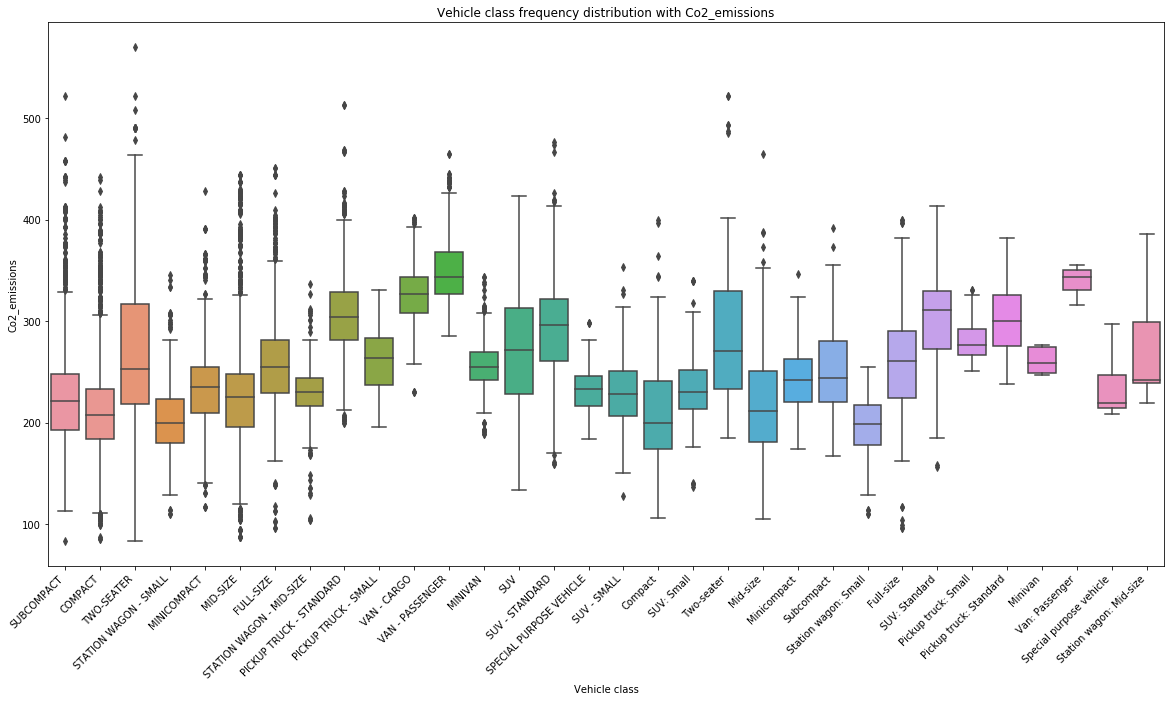

In [26]:
# Let's visualize the above output for the Vehicle_class feature with respect to Co2 emissions.
plt.figure(figsize=(20,10))
sns.boxplot(x=data.Vehicle_class, y=data.Co2_emissions, data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Vehicle class')
plt.ylabel('Co2_emissions')
plt.title('Vehicle class frequency distribution with Co2_emissions')
plt.show()

**We see that the distributions of Co_2 emissions between the different vehicle class categories have an intermediate overlap, and so the Vehicle_class feature would be an intermediate predictor of Co_2 emissions.**

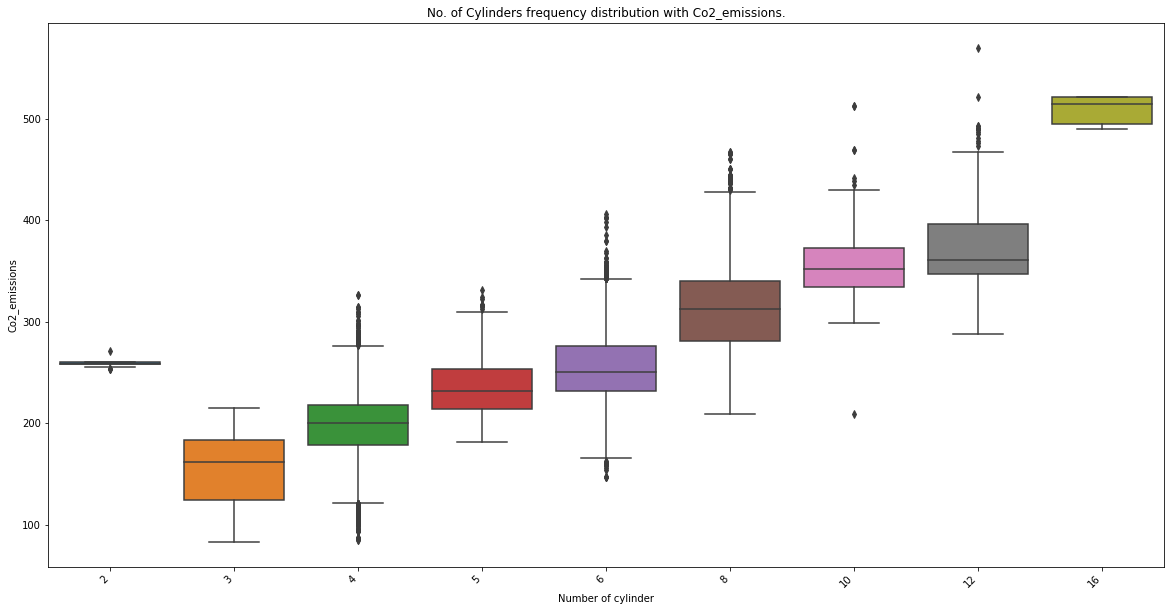

In [27]:
# Let's visualize the above output for the Cylinders feature
plt.figure(figsize=(20,10))
sns.boxplot(x=data.Cylinders, y=data.Co2_emissions, data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Number of cylinder')
plt.ylabel('Co2_emissions')
plt.title('No. of Cylinders frequency distribution with Co2_emissions.')
plt.show()

**Here we see that the distribution of Co2_emissons between the different number of cylinders in a car engine, are distinct enough to take Cylinders as a potential good predictor of Co2_emissions.**

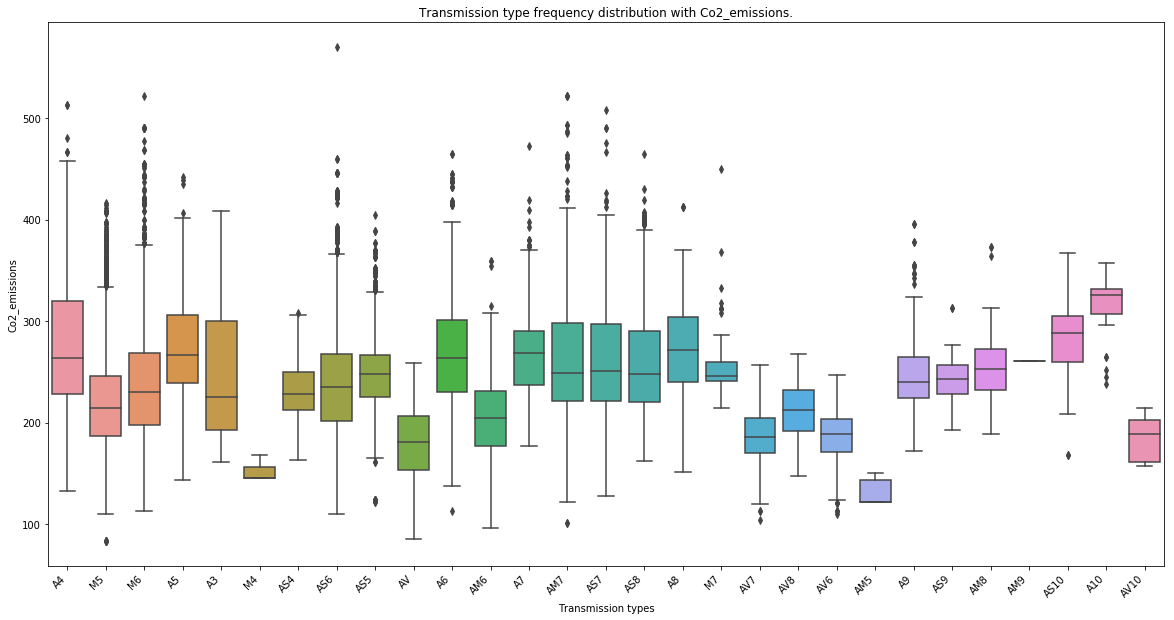

In [28]:
# Let's visualize the above output for the Transmission feature
plt.figure(figsize=(20,10))
sns.boxplot(x=data.Transmission, y=data.Co2_emissions, data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Transmission types')
plt.ylabel('Co2_emissions')
plt.title('Transmission type frequency distribution with Co2_emissions.')
plt.show()

**Here we see that the distribution of Co2_emissons between the different type of transmission in a car engine, are partially distinct enough to take Cylinders as a potential good predictor of Co2_emissions, and partially have an intermediate overlap, and so the Vehicle_class feature can also be an intermediate predictor of Co_2 emissions.**

<function matplotlib.pyplot.show(*args, **kw)>

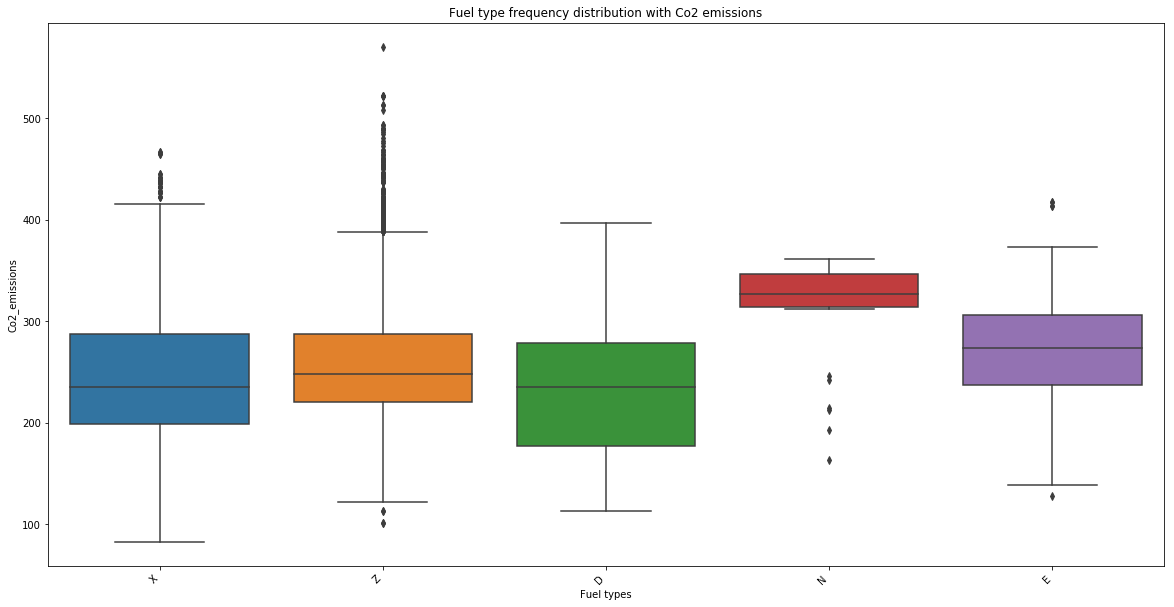

In [29]:
# Let's visualize the above output for the Fuel feature
plt.figure(figsize=(20,10))
sns.boxplot(x=data.Fuel, y=data.Co2_emissions, data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('Fuel types')
plt.ylabel('Co2_emissions')
plt.title('Fuel type frequency distribution with Co2 emissions')
plt.show

**We see that the distributions of Co_2 emissions between the different fuel types used in car have an intermediate overlap, and so the Fuel feature would be an intermediate predictor of Co_2 emissions.**

C:\Users\Tradeoff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


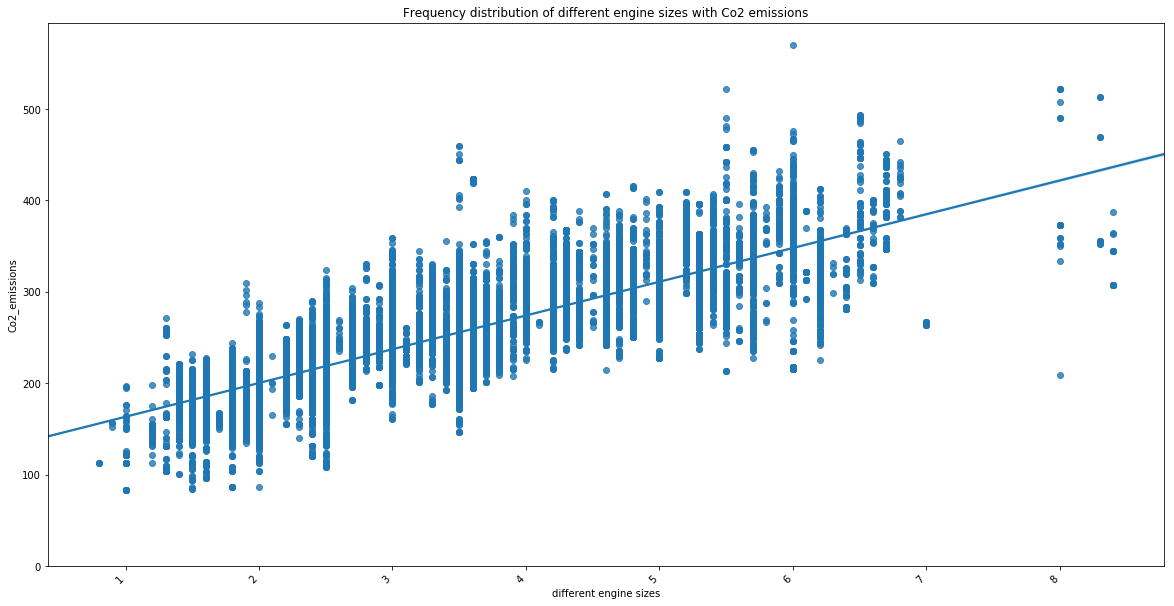

In [30]:
# Engine size as potential predictor variable of Co2 emissions.
plt.figure(figsize=(20,10))
sns.regplot(x="Engine_size", y="Co2_emissions", data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylim(0,)
plt.xlabel('different engine sizes')
plt.ylabel('Co2_emissions')
plt.title('Frequency distribution of different engine sizes with Co2 emissions')
plt.show()

**As the engine size goes up, the Co2 emissions goes up: this indicates a positive direct correlation between these two variables. Engine size seems like a pretty good predictor of Co2 emissions, since the regression line is almost a perfect diagonal line.**  
**We can notice the presence of some outliers in this feature which we will treat seperately later.**</p>

C:\Users\Tradeoff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


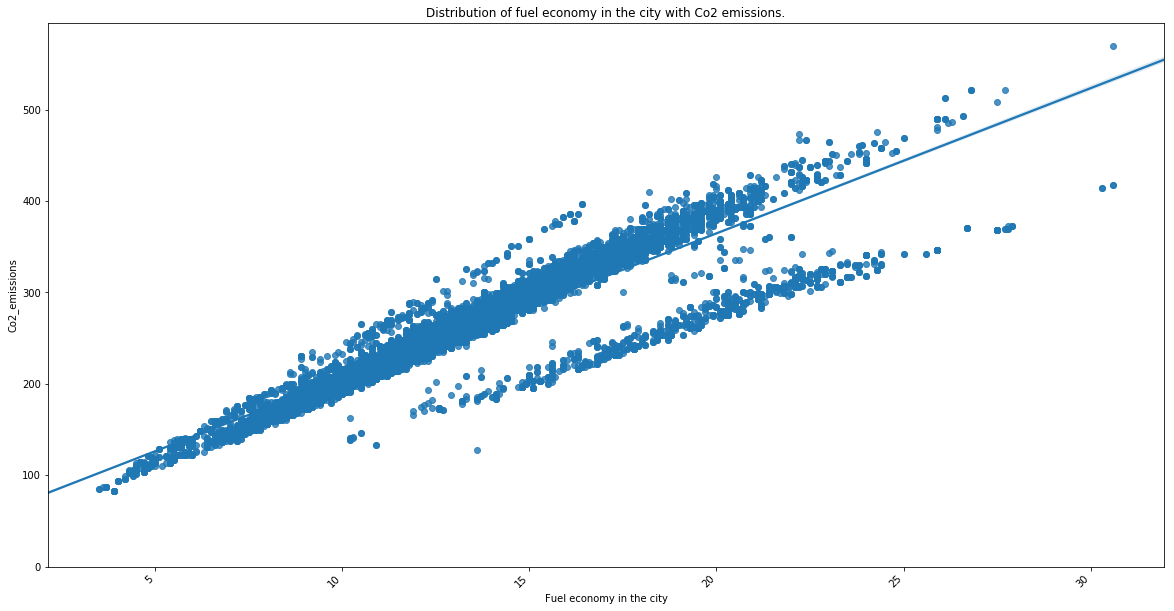

In [31]:
## Fuel consumption by cars in city roads as potential predictor variable of Co2 emissions.
plt.figure(figsize=(20,10))
sns.regplot(x="Fuel_con_city", y="Co2_emissions", data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylim(0,)
plt.xlabel('Fuel economy in the city')
plt.ylabel('Co2_emissions')
plt.title('Distribution of fuel economy in the city with Co2 emissions.')
plt.show()

**As the fuel consumption by cars in city conditins goes up, the Co2 emissions  also goes up: this indicates a positive direct correlation between these two variables, and it also seems like a pretty good predictor of Co2 emissions, since the regression line is almost a perfect diagonal line.**  

C:\Users\Tradeoff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


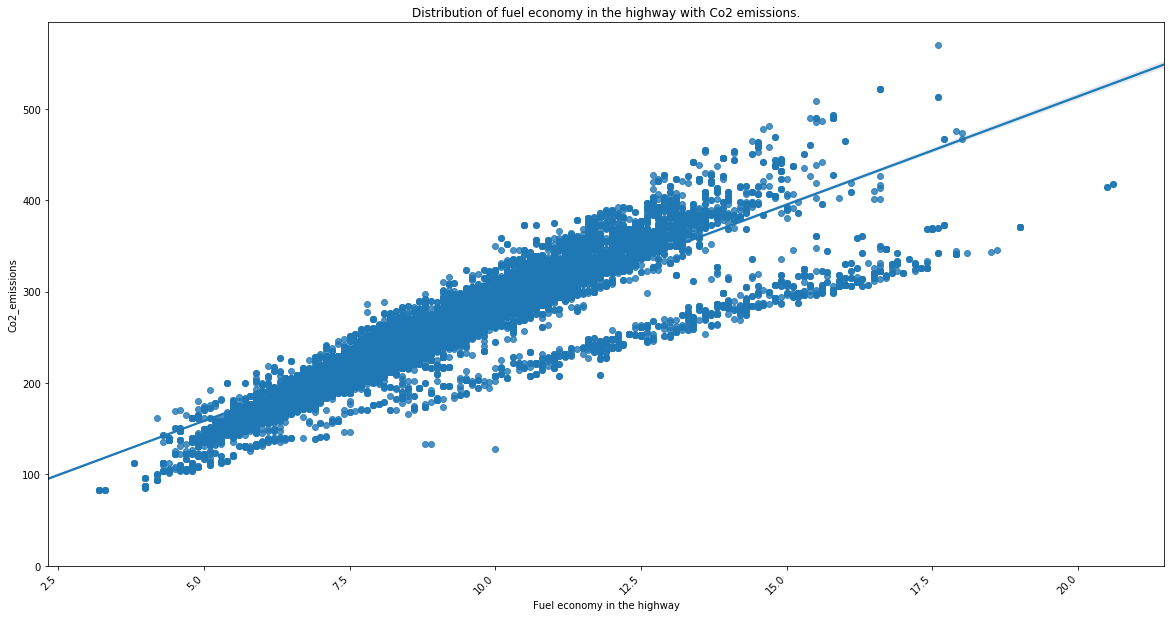

In [32]:
## Fuel consumption by cars in highway roads as potential predictor variable of Co2 emissions.
plt.figure(figsize=(20,10))
sns.regplot(x="Fuel_con_hwy", y="Co2_emissions", data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylim(0,)
plt.xlabel('Fuel economy in the highway')
plt.ylabel('Co2_emissions')
plt.title('Distribution of fuel economy in the highway with Co2 emissions.')
plt.show()

**As the fuel consumption by cars in highway conditins goes up, the Co2 emissions  also goes up: this indicates a positive direct correlation between these two variables, and it also seems like a pretty good predictor of Co2 emissions, since the regression line is almost a perfect diagonal line.**  

C:\Users\Tradeoff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


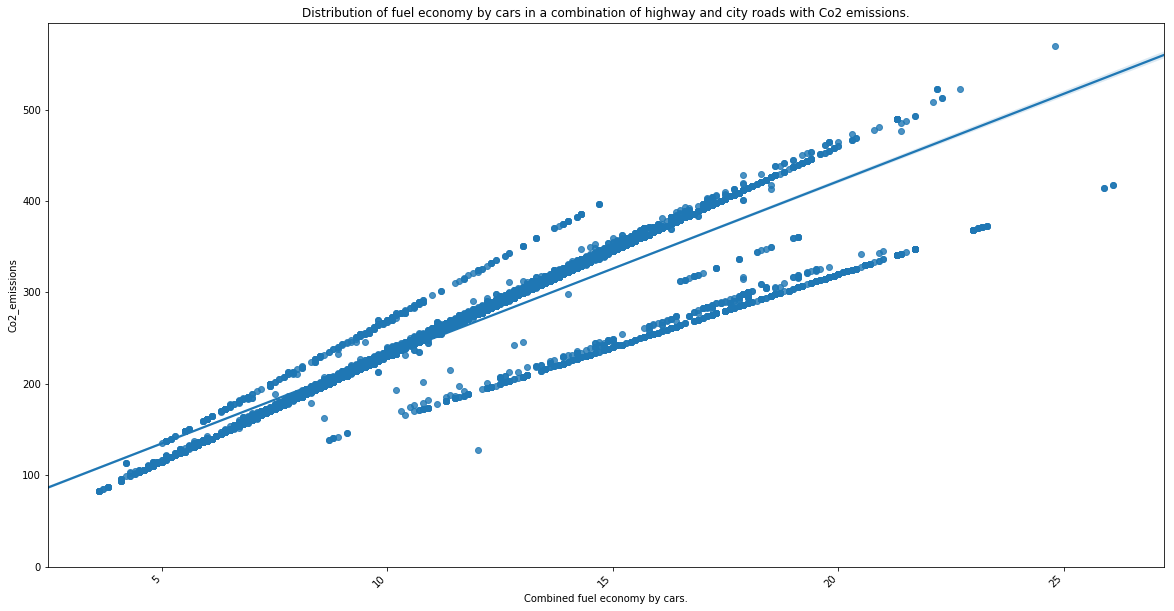

In [33]:
## Fuel consumption by cars in a combination of highway and city roads as potential predictor variable of Co2 emissions.
plt.figure(figsize=(20,10))
sns.regplot(x="Fuel_con_comb", y="Co2_emissions", data=data)
plt.xticks(rotation=45, horizontalalignment='right')
plt.ylim(0,)
plt.xlabel('Combined fuel economy by cars.')
plt.ylabel('Co2_emissions')
plt.title('Distribution of fuel economy by cars in a combination of highway and city roads with Co2 emissions.')
plt.show()

**As the fuel consumption by cars in a combination of highway and city conditins goes up, the Co2 emissions  also goes up: this indicates a positive direct correlation between these two variables, and it also seems like a pretty good predictor of Co2 emissions, since the regression line is almost a perfect diagonal line.**  

**Now that we have vizualized the realtionship between our features and our target variable, let's see the strength of this relationship; we can do so by calculating the corelational coefficient between out numerical features.**

In [34]:
data.corr()

,Engine_size,Cylinders,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
Engine_size,1.000000,0.909162,0.825511,0.760273,0.812832,0.830066
Cylinders,0.909162,1.000000,0.791049,0.698095,0.768055,0.795040
Fuel_con_city,0.825511,0.791049,1.000000,0.946864,0.993377,0.924512
Fuel_con_hwy,0.760273,0.698095,0.946864,1.000000,0.976968,0.901747
Fuel_con_comb,0.812832,0.768055,0.993377,0.976968,1.000000,0.928143
Co2_emissions,0.830066,0.795040,0.924512,0.901747,0.928143,1.000000


**Okay lets check the statistical significance of these correlation values.**

In [35]:
from scipy import stats

**Engine_size VS Co2_emissions.**

In [36]:
pearson_coef, p_value  = stats.spearmanr(data.Engine_size, data.Co2_emissions)
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.850833758258211  with a P-value of P = 0.0


**Since the p-value is  <  0.001, the correlation between Engine_size and Co2_emissions is statistically significant.**

**Fuel_con_city VS Co2_emissions.**

In [37]:
pearson_coef, p_value  = stats.spearmanr(data.Fuel_con_city, data.Co2_emissions)
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.9572174373519916  with a P-value of P = 0.0


**Since the p-value is < 0.001, the correlation between Fuel_con_city and Co2_emissions is statistically significant.**

**Fuel_con_hwy VS Co2_emissions.**

In [38]:
pearson_coef, p_value  = stats.spearmanr(data.Fuel_con_hwy, data.Co2_emissions)
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.9458826394658655  with a P-value of P = 0.0


**Since the p-value is < 0.001, the correlation between Fuel_con_hwy and Co2_emissions is statistically significant.**

**Fuel_con_comb VS Co2_emissions.**

In [39]:
pearson_coef, p_value  = stats.spearmanr(data.Fuel_con_comb, data.Co2_emissions)
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.967001503346109  with a P-value of P = 0.0


**Since the p-value is < 0.001, the correlation between Fuel_con_comb and Co2_emissions is statistically significant.**

**Let's do an initial descriptive statistical analysis of our features.**

In [40]:
data.describe()  # only accounts for the numerical fetures.

,Engine_size,Cylinders,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
count,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000,24092.000000
mean,3.369077,5.857463,12.843106,8.905114,11.071625,250.925203
std,1.338363,1.781406,3.462665,2.267760,2.890290,59.512462
min,0.800000,2.000000,3.500000,3.200000,3.600000,83.000000
25%,2.300000,4.000000,10.500000,7.300000,9.100000,209.000000
50%,3.000000,6.000000,12.400000,8.400000,10.600000,244.000000
75%,4.300000,8.000000,14.800000,10.200000,12.800000,289.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,570.000000


In [41]:
data.describe(include = 'object') # also accounts for the categorical features.

,Year_make_model,Vehicle_class,Transmission,Fuel
count,24092,24092,24092,24092
unique,14322,32,29,5
top,2001-DODGE-RAM 1500,COMPACT,A4,X
freq,9,3329,5491,13560


**Okay let's do a deeper analysis of our categorical features.**

In [42]:
catg_VC_Co2 = data[['Vehicle_class','Co2_emissions']]
catg_VC_Co2.head()

,Vehicle_class,Co2_emissions
0,SUBCOMPACT,202
1,SUBCOMPACT,193
2,SUBCOMPACT,191
3,COMPACT,251
4,COMPACT,260


In [43]:
catg_VC_Co2 = catg_VC_Co2.groupby(['Vehicle_class'],as_index=False).mean()
catg_VC_Co2.sort_values("Co2_emissions", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
catg_VC_Co2

,Vehicle_class,Co2_emissions
25,Station wagon: Small,193.300000
16,STATION WAGON - SMALL,203.297998
1,Compact,212.030769
0,COMPACT,212.200060
7,Mid-size,219.590038
17,SUBCOMPACT,225.717913
4,MID-SIZE,226.681250
19,SUV - SMALL,229.036853
15,STATION WAGON - MID-SIZE,229.372632
23,Special purpose vehicle,230.250000


**From our data, it seems that vehicles in the Station wagon: Small	 class are, on average, the least expensive in terms of Co2 emissions by cars, vehicles in the Van:Passenger class most expensive in terms of Co2 emissoins by them.**

In [44]:
catg_CY_Co2 = data[['Cylinders','Co2_emissions']]
catg_CY_Co2.head()

,Cylinders,Co2_emissions
0,4,202
1,4,193
2,4,191
3,6,251
4,6,260


In [45]:
catg_CY_Co2 = catg_CY_Co2.groupby(['Cylinders'],as_index=False).mean()
catg_CY_Co2.sort_values("Co2_emissions", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
catg_CY_Co2

,Cylinders,Co2_emissions
1,3,157.553846
2,4,198.453886
3,5,234.825424
4,6,255.807649
0,2,258.176471
5,8,313.649072
6,10,354.785714
7,12,373.418919
8,16,509.000000


**From our data, it seems that vehicles with 3 cylinders are, on average, the least expensive in terms of Co2 emissions by cars, vehicles 16 cylinders are on average most expensive in terms of Co2 emissoins by them.**

In [46]:
catg_TR_Co2 = data[['Transmission', 'Co2_emissions']]
catg_TR_Co2.head()

,Transmission,Co2_emissions
0,A4,202
1,M5,193
2,M5,191
3,A4,251
4,A4,260


In [47]:
catg_TR_Co2 = catg_TR_Co2.groupby(['Transmission'],as_index=False).mean()
catg_TR_Co2.sort_values("Co2_emissions", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
catg_TR_Co2

,Transmission,Co2_emissions
8,AM5,131.333333
25,M4,152.666667
20,AV,177.742779
21,AV10,185.090909
22,AV6,185.840000
23,AV7,189.991736
9,AM6,205.128866
24,AV8,214.125000
26,M5,223.729511
14,AS4,232.155039


**From our data, it seems that vehicles with AM5 type of transmission are, on average, the least expensive in terms of Co2 emissions by cars, vehicles with A10 type of transmission are on average most expensive in terms of Co2 emissoins by them.**

In [48]:
catg_FU_Co2 = data[['Fuel', 'Co2_emissions']]
catg_FU_Co2.head()

,Fuel,Co2_emissions
0,X,202
1,X,193
2,Z,191
3,Z,251
4,Z,260


In [49]:
catg_FU_Co2 = catg_FU_Co2.groupby(['Fuel'],as_index=False).mean()
catg_FU_Co2.sort_values("Co2_emissions", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')
catg_FU_Co2

,Fuel,Co2_emissions
0,D,237.478632
3,X,243.964602
4,Z,259.350451
1,E,269.977099
2,N,315.538462


**From our data, it seems that vehicles using the D type of fuel are, on average, the least expensive in terms of Co2 emissions by cars, vehicles using the N type of fuel are on average most expensive in terms of Co2 emissoins by them.**

In [50]:
catg_features = data[['Vehicle_class', 'Cylinders', 'Transmission', 'Fuel', 'Co2_emissions']]
catg_features.head()

,Vehicle_class,Cylinders,Transmission,Fuel,Co2_emissions
0,SUBCOMPACT,4,A4,X,202
1,SUBCOMPACT,4,M5,X,193
2,SUBCOMPACT,4,M5,Z,191
3,COMPACT,6,A4,Z,251
4,COMPACT,6,A4,Z,260


In [51]:
catg_features = catg_features.groupby(['Vehicle_class', 'Cylinders', 'Transmission', 'Fuel'],as_index=False).mean()
catg_features.sort_values("Co2_emissions", axis = 0, ascending = True, 
                 inplace = True, na_position ='last')

In [52]:
catg_features.head()

,Vehicle_class,Cylinders,Transmission,Fuel,Co2_emissions
1230,TWO-SEATER,3,M5,X,83.00
244,Full-size,4,AM6,X,98.75
164,FULL-SIZE,4,AM6,X,99.25
1231,TWO-SEATER,3,M6,D,113.00
1226,TWO-SEATER,3,A6,D,113.00


In [53]:
catg_features.tail()

,Vehicle_class,Cylinders,Transmission,Fuel,Co2_emissions
1323,Two-seater,12,AM7,Z,489.5
1300,TWO-SEATER,16,AS7,Z,496.0
609,PICKUP TRUCK - STANDARD,10,A4,Z,513.0
1324,Two-seater,16,AM7,Z,522.0
1299,TWO-SEATER,16,AM7,Z,522.0


**From our data, it seems that -**  
* <b>vehicles in the class TWO-SEATER with 3 cylinders with M5 type of transmission and using X fuel type are, on average the least expensive in terms of Co2 emissions by cars,</b> and  
* <b>vehicles  in the class Two-SEATER with 16 cylinders with AM7 type of transmission and using Z fuel type are, on average most expensive in terms of Co2 emissoins by them.</b>

**Outlier detection and removal in the features of our data.**

In [54]:
# Function: print_quantile_info(qu_dataset, qu_field)
#   Print out the following information about the data
#   - interquartile range
#   - upper_inner_fence
#   - lower_inner_fence
#   - upper_outer_fence
#   - lower_outer_fence
#   - percentage of records out of inner fences
#   - percentage of records out of outer fences
# Input: 
#   - pandas dataframe (qu_dataset)
#   - name of the column to analyze (qu_field)
# Output:
#   None

def print_quantile_info(qu_dataset, qu_field):
    a = qu_dataset[qu_field].describe()
    
    iqr = a["75%"] - a["25%"]
    print("interquartile range:", iqr)
    
    upper_inner_fence = a["75%"] + 1.5 * iqr
    lower_inner_fence = a["25%"] - 1.5 * iqr
    print("upper_inner_fence:", upper_inner_fence)
    print("lower_inner_fence:", lower_inner_fence)
    
    upper_outer_fence = a["75%"] + 3 * iqr
    lower_outer_fence = a["25%"] - 3 * iqr
    print("upper_outer_fence:", upper_outer_fence)
    print("lower_outer_fence:", lower_outer_fence)
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_inner_fence])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_inner_fence])
    percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
    print("percentage of records out of inner fences for "  +qu_field+ " is: %.2f"% (percentage))
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_outer_fence])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_outer_fence])
    percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
    print("percentage of records out of outer fences for "  +qu_field+ " is: %.2f"% (percentage))
    
    
    # Function: remove_outliers_using_quantiles(qu_dataset, qu_field, qu_fence)
#   1- Remove outliers according to the given fence value and return new dataframe.
#   2- Print out the following information about the data
#      - interquartile range
#      - upper_inner_fence
#      - lower_inner_fence
#      - upper_outer_fence
#      - lower_outer_fence
#      - percentage of records out of inner fences
#      - percentage of records out of outer fences
# Input: 
#   - pandas dataframe (qu_dataset)
#   - name of the column to analyze (qu_field)
#   - inner (1.5*iqr) or outer (3.0*iqr) (qu_fence) values: "inner" or "outer"
# Output:
#   - new pandas dataframe (output_dataset)

def remove_outliers_using_quantiles(qu_dataset, qu_field, qu_fence):
    a = qu_dataset[qu_field].describe()
    
    iqr = a["75%"] - a["25%"]
    print("interquartile range:", iqr)
    
    upper_inner_fence = a["75%"] + 1.5 * iqr
    lower_inner_fence = a["25%"] - 1.5 * iqr
    print("upper_inner_fence:", upper_inner_fence)
    print("lower_inner_fence:", lower_inner_fence)
    
    upper_outer_fence = a["75%"] + 3 * iqr
    lower_outer_fence = a["25%"] - 3 * iqr
    print("upper_outer_fence:", upper_outer_fence)
    print("lower_outer_fence:", lower_outer_fence)
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_inner_fence])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_inner_fence])
    percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
    print("percentage of records out of inner fences: %.2f"% (percentage))
    
    count_over_upper = len(qu_dataset[qu_dataset[qu_field]>upper_outer_fence])
    count_under_lower = len(qu_dataset[qu_dataset[qu_field]<lower_outer_fence])
    percentage = 100 * (count_under_lower + count_over_upper) / a["count"]
    print("percentage of records out of outer fences: %.2f"% (percentage))
    
    if qu_fence == "inner":
        output_dataset = qu_dataset[qu_dataset[qu_field]<=upper_inner_fence]
        output_dataset = output_dataset[output_dataset[qu_field]>=lower_inner_fence]
    elif qu_fence == "outer":
        output_dataset = qu_dataset[qu_dataset[qu_field]<=upper_outer_fence]
        output_dataset = output_dataset[output_dataset[qu_field]>=lower_outer_fence]
    else:
        output_dataset = qu_dataset
    
    print("length of input dataframe:", len(qu_dataset))
    print("length of new dataframe after outlier removal:", len(output_dataset))
    
    return output_dataset

In [55]:
for col in ['Engine_size', 'Cylinders', 'Fuel_con_city', 'Fuel_con_hwy', 'Fuel_con_comb', 'Co2_emissions']:
    print_quantile_info(data, col)

# data.dropna(inplace=True)
# new_dataset = remove_outliers_using_quantiles(data, "Fuel_con_city", "outer")

interquartile range: 2.0
upper_inner_fence: 7.3
lower_inner_fence: -0.7000000000000002
upper_outer_fence: 10.3
lower_outer_fence: -3.7
percentage of records out of inner fences for Engine_size is: 0.17
percentage of records out of outer fences for Engine_size is: 0.00
interquartile range: 4.0
upper_inner_fence: 14.0
lower_inner_fence: -2.0
upper_outer_fence: 20.0
lower_outer_fence: -8.0
percentage of records out of inner fences for Cylinders is: 0.02
percentage of records out of outer fences for Cylinders is: 0.00
interquartile range: 4.300000000000001
upper_inner_fence: 21.25
lower_inner_fence: 4.049999999999999
upper_outer_fence: 27.700000000000003
lower_outer_fence: -2.400000000000002
percentage of records out of inner fences for Fuel_con_city is: 2.18
percentage of records out of outer fences for Fuel_con_city is: 0.05
interquartile range: 2.8999999999999995
upper_inner_fence: 14.549999999999999
lower_inner_fence: 2.95
upper_outer_fence: 18.9
lower_outer_fence: -1.3999999999999995


**We can clearly see that our dataset does not contain outliers as such that it is necessary to remove them.**

**Okay so now that we hae a deeper understanding of our dataset and its features,**  
**let's move forward with the next steps in processing the dataset.**

In [56]:
dummies_VC = pd.get_dummies(data['Vehicle_class'], prefix='Vehicle_class', prefix_sep = '_', drop_first=False)
dummies_C = pd.get_dummies(data['Cylinders'], prefix='cylinder', prefix_sep = '_', drop_first=False)
dummies_TR = pd.get_dummies(data['Transmission'], prefix='Transmission_', prefix_sep = 'type_', drop_first=False)
dummies_F = pd.get_dummies(data['Fuel'], prefix='Fuel_', prefix_sep = 'type_', drop_first=False)

print(dummies_VC.head(),
dummies_C.head(),
dummies_TR.head(),
dummies_F.head())

   Vehicle_class_COMPACT  Vehicle_class_Compact  Vehicle_class_FULL-SIZE  \
0                      0                      0                        0   
1                      0                      0                        0   
2                      0                      0                        0   
3                      1                      0                        0   
4                      1                      0                        0   

   Vehicle_class_Full-size  Vehicle_class_MID-SIZE  Vehicle_class_MINICOMPACT  \
0                        0                       0                          0   
1                        0                       0                          0   
2                        0                       0                          0   
3                        0                       0                          0   
4                        0                       0                          0   

   Vehicle_class_MINIVAN  Vehicle_class_Mid-size  Vehicl

In [57]:
data = data.drop(['Vehicle_class', 'Cylinders', 'Transmission', 'Fuel'], 1)
data.head()

,Year_make_model,Engine_size,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions
0,1995-ACURA-INTEGRA,1.8,10.2,7.0,8.8,202
1,1995-ACURA-INTEGRA,1.8,9.6,7.0,8.4,193
2,1995-ACURA-INTEGRA GS-R,1.8,9.4,7.0,8.3,191
3,1995-ACURA-LEGEND,3.2,12.6,8.9,10.9,251
4,1995-ACURA-LEGEND COUPE,3.2,13.0,9.3,11.3,260


In [58]:
data = pd.concat([data, dummies_VC, dummies_C, dummies_TR, dummies_F], axis=1)
data.head()

,Year_make_model,Engine_size,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions,Vehicle_class_COMPACT,Vehicle_class_Compact,Vehicle_class_FULL-SIZE,Vehicle_class_Full-size,...,Transmission_type_AV8,Transmission_type_M4,Transmission_type_M5,Transmission_type_M6,Transmission_type_M7,Fuel_type_D,Fuel_type_E,Fuel_type_N,Fuel_type_X,Fuel_type_Z
0,1995-ACURA-INTEGRA,1.8,10.2,7.0,8.8,202,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1995-ACURA-INTEGRA,1.8,9.6,7.0,8.4,193,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1995-ACURA-INTEGRA GS-R,1.8,9.4,7.0,8.3,191,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1995-ACURA-LEGEND,3.2,12.6,8.9,10.9,251,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1995-ACURA-LEGEND COUPE,3.2,13.0,9.3,11.3,260,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [59]:
data.shape

(24092, 81)

In [60]:
data = data.drop(['Year_make_model'], 1)  # droping the ID feature from our dataset because it is not necesary in our prediction.
data.head()

,Engine_size,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Co2_emissions,Vehicle_class_COMPACT,Vehicle_class_Compact,Vehicle_class_FULL-SIZE,Vehicle_class_Full-size,Vehicle_class_MID-SIZE,...,Transmission_type_AV8,Transmission_type_M4,Transmission_type_M5,Transmission_type_M6,Transmission_type_M7,Fuel_type_D,Fuel_type_E,Fuel_type_N,Fuel_type_X,Fuel_type_Z
0,1.8,10.2,7.0,8.8,202,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.8,9.6,7.0,8.4,193,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.8,9.4,7.0,8.3,191,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3.2,12.6,8.9,10.9,251,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.2,13.0,9.3,11.3,260,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
x_data = data.drop('Co2_emissions', axis = 1)
x.head()

,Engine_size,Fuel_con_city,Fuel_con_hwy,Fuel_con_comb,Vehicle_class_COMPACT,Vehicle_class_Compact,Vehicle_class_FULL-SIZE,Vehicle_class_Full-size,Vehicle_class_MID-SIZE,Vehicle_class_MINICOMPACT,...,Transmission_type_AV8,Transmission_type_M4,Transmission_type_M5,Transmission_type_M6,Transmission_type_M7,Fuel_type_D,Fuel_type_E,Fuel_type_N,Fuel_type_X,Fuel_type_Z
0,1.8,10.2,7.0,8.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.8,9.6,7.0,8.4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,1.8,9.4,7.0,8.3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3.2,12.6,8.9,10.9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3.2,13.0,9.3,11.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [64]:
y_data = data[['Co2_emissions']]
y_data.head()

,Co2_emissions
0,202
1,193
2,191
3,251
4,260


In [65]:
print(x_data.shape, y_data.shape)

(24092, 79) (24092, 1)


In [66]:
!{sys.executable} -m pip install sklearn

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [80]:
# intermediate/test split (gives us test set)
x_intermediate, x_test, y_intermediate, y_test = train_test_split(x_data, 
                                                                  y_data, 
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=15)

# train/validation split (gives us train and validation sets)
x_train, x_validation, y_train, y_validation = train_test_split(x_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=2018)
# delete intermediate variables
del x_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y_data),2),
                                                       round(len(y_validation)/len(y_data),2),
                                                       round(len(y_test)/len(y_data),2)))

print("number of test samples : {}, number of validation samples : {}, number of training samples : {}".format(len(x_train), 
                                                                                                               len(x_validation),
                                                                                                               len(x_test)))




train: 0.6% | validation: 0.2% | test 0.2%
number of test samples : 14454, number of validation samples : 4819, number of training samples : 4819


In [82]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [91]:
print(x_train.shape,
x_validation.shape,
x_test.shape,
y_train.shape,
y_validation.shape,
y_test.shape,
yhat_validation.shape)

(14454, 79) (4819, 79) (4819, 79) (14454, 1) (4819, 1) (4819, 1) (4819, 1)


In [81]:
lre = LinearRegression(fit_intercept = True, normalize= True, copy_X = True)

In [83]:
lre.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [86]:
yhat_validation = lre.predict(x_validation)

In [92]:
lre.score(y_validation, yhat_validation)

ValueError: shapes (4819,1) and (79,1) not aligned: 1 (dim 1) != 79 (dim 0)

In [ ]:
print("The R^2 score for the TRAINING and TESTING set are as follows {}, {}:".format(lre.score(x_train, y_train) ,lre.score(x_test, y_test)))

In [ ]:
yhat_train = lre.predict(x_train)
yhat_train

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [ ]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [ ]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [ ]:
Rcross = cross_val_score(lre, x_data, y_data, cv=4)

**okay so let's encode our categorical features into integer categories so that the algorith can understand the feature information.**

* https://www.kaggle.com/vjchoudhary7/hr-analytics-case-study - Logistic Regession
* https://www.kaggle.com/vpfahad/telecom-churn-data-sets - 
* https://www.kaggle.com/hpratt/hiring-decision-with-scikit-learn/kernels - 
* https://www.kaggle.com/mrferozi/flight-delays - 
* https://www.kaggle.com/uciml/pima-indians-diabetes-database - 
* https://www.kaggle.com/himanshupoddar/zomato-bangalore-restaurants - 
* https://www.kaggle.com/anderas/car-consume - 
* https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 - 
* https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho - 
* https://www.kaggle.com/ranja7/bankloan-tobeapproved - 
* https://www.kaggle.com/noordeen/insurance-premium-prediction - Multivariate Linear Regression.
* https://www.kaggle.com/teertha/ushealthinsurancedataset - 
* https://www.kaggle.com/mirichoi0218/insurance - 
* https://www.kaggle.com/skihikingkevin/online-p2p-lending - 
* https://www.kaggle.com/rikdifos/credit-card-approval-prediction - 
* https://www.kaggle.com/broach/button-tone-sz - 
* https://www.kaggle.com/karvalo/indian-card-payment-data-set - 
* https://www.kaggle.com/dhimananubhav/equity-investing-fundamental-analysis - 
* 




Understanding the Table																			
Model	4WD/4X4 = Four-wheel drive																		
	AWD = All-wheel drive																		
	CNG = Compressed natural gas																		
	FFV = Flexible-fuel vehicle																		
	NGV = Natural gas vehicle																		
	# = High output engine that provides more power than the standard engine of the same size																		
Transmission	A = Automatic																		
	AM = Automated manual																		
	AS = Automatic with select shift																		
	AV = Continuously variable																		
	M = Manual																		
	3 – 10 = Number of gears																		
Fuel Type	X = Regular gasoline																		
	Z = Premium gasoline																		
	D = Diesel																		
	E = Ethanol (E85)																		
	N = Natural Gas																		
Fuel Consumption	City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg)																		
CO2 Emissions (g/km)	Estimated tailpipe carbon dioxide emissions (in grams per kilometre) are based on fuel type and the combined fuel consumption rating.																		
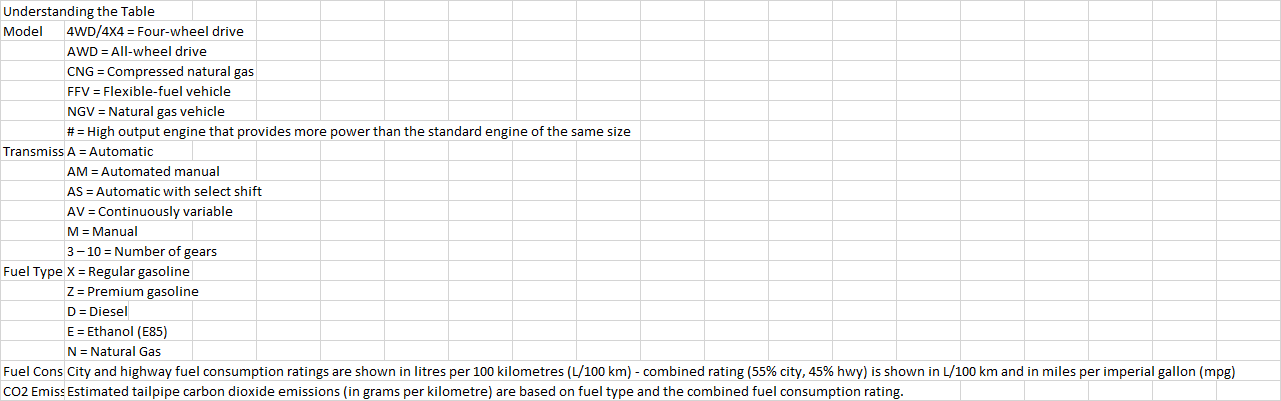